# Load One Icosphere

Unimplemented OBJ format statement 's' on line 's 0'


torch.Size([80, 3, 3])


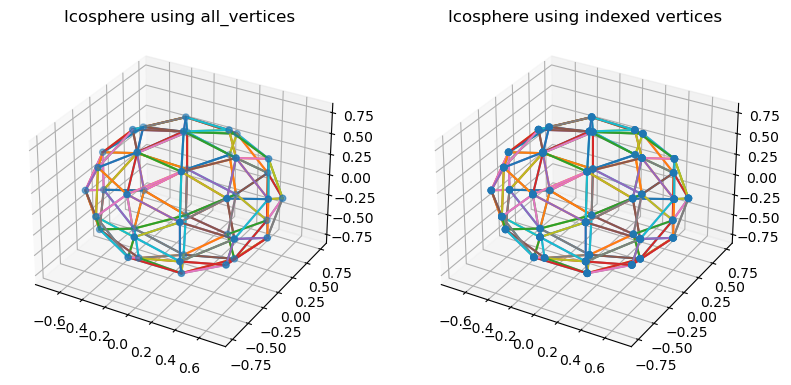

In [16]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import pywavefront

scale = 0.75
scene = pywavefront.Wavefront("icosphere.obj", collect_faces=True)

all_vertices = scale * torch.tensor(scene.vertices, dtype=torch.float)  # Some might be wasted if we had multiple faces
faces = torch.tensor(scene.meshes["Icosphere"].faces, dtype=torch.long)  # F, 3
vertices = torch.index_select(  # F, 3, 3 ... [f][v] = [x, y, z]
    input=all_vertices,  # V, 3
    dim=0,
    index=faces.view(-1),  # F, 3
).view(-1, 3, 3)
print(vertices.shape)


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("Icosphere using all_vertices")
ax.scatter(
    all_vertices[:, 0].tolist(),
    all_vertices[:, 1].tolist(),
    all_vertices[:, 2].tolist(),
)
for face in faces.tolist():
    for (i, j) in [(0, 1), (1, 2), (0, 2)]:
        vi = all_vertices[face[i], :]
        vj = all_vertices[face[j], :]
        ax.plot([vi[0], vj[0]], [vi[1], vj[1]], zs=[vi[2], vj[2]])

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("Icosphere using indexed vertices")
ax.scatter(
    vertices[:, :, 0].view(-1).tolist(),
    vertices[:, :, 1].view(-1).tolist(),
    vertices[:, :, 2].view(-1).tolist(),
)
for face in faces.tolist():
    for (i, j) in [(0, 1), (1, 2), (0, 2)]:
        vi = all_vertices[face[i], :]
        vj = all_vertices[face[j], :]
        ax.plot([vi[0], vj[0]], [vi[1], vj[1]], zs=[vi[2], vj[2]])
plt.show()

# Set Up Ray Tracing variables

In [3]:
all_vertices.max(0)

torch.return_types.max(
values=tensor([0.9511, 1.0000, 1.0000]),
indices=tensor([22, 11, 24]))

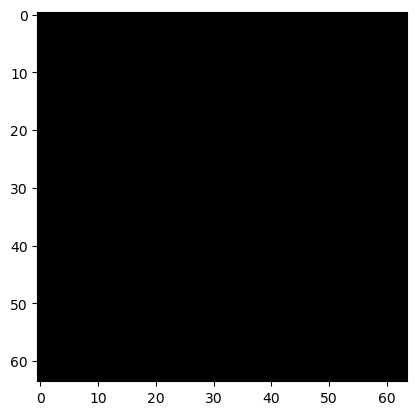

In [23]:

H = 64
W = 64
C = 3
B = 1
image = torch.zeros(C, H, W)  # TODO: dtype?
camera = torch.tensor([0, 0, 3])  # z=1
screen_z = 2

pixel_size_at_screen_z = scale / H

def plot_image(
    image: torch.Tensor, 
    ax: plt.Axes = None,
    show: bool = False,
) -> None:
    # image: B
    if ax is None:
        ax = plt.gca()
        show = True
    
    ax.imshow(image.detach().permute(1, 2, 0))
    if show:
        plt.show()
    
plot_image(image)

In [5]:
@torch.no_grad()
def point_in_triangle(point: torch.Tensor, triangle: torch.Tensor) -> bool:
    # point: (1, 3)
    # triangle: (V, 3) where V=3
    # use https://gdbooks.gitbooks.io/3dcollisions/content/Chapter4/point_in_triangle.html
    triangle_relative_to_point = triangle - point.view(1, 3)
    vertex0 = triangle_relative_to_point[0, :]
    vertex1 = triangle_relative_to_point[1, :]
    vertex2 = triangle_relative_to_point[2, :]

    # Now cross produce them
    cross01 = torch.cross(vertex0, vertex1)
    cross12 = torch.cross(vertex1, vertex2)
    cross20 = torch.cross(vertex2, vertex0)
    return (torch.dot(cross01, cross12) > 0).item() and (torch.dot(cross12, cross20) > 0).item()

print("origin in yz", point_in_triangle(
    torch.tensor([0, 0, 0], dtype=torch.float), torch.tensor([[0, 1, 0], [0, 0, 1], [0, -1, -1]], dtype=torch.float)
))

print("origin in yz", point_in_triangle(
    torch.tensor([0, 0, 0], dtype=torch.float), torch.tensor([[0, 0, 1], [0, 1, 0], [0, -1, -1]], dtype=torch.float)
))

print("origin in x=1", point_in_triangle(
    torch.tensor([0, 0, 0], dtype=torch.float), torch.tensor([[1, 1, 0], [1, 0, 1], [1, -1, -1]], dtype=torch.float)
))

origin in yz True
origin in yz True
origin in x=1 False


In [6]:
@torch.no_grad()
def line_plane_intersection(line: torch.Tensor, triangle: torch.Tensor, verbose: bool = False) -> torch.Tensor:
    # line: 2, 3
    # triangle: 3, 3
    # output: 1, 3
    edge01 = triangle[0, :] - triangle[1, :]
    edge12 = triangle[1, :] - triangle[2, :]
    normal = torch.cross(edge01, edge12)
    unit_normal = normal / torch.linalg.norm(normal)
    line_direction = line[1, :] - line[0, :]
    reference_direction = line[0, :] - triangle[0, :]
    if verbose:
        print(f"{unit_normal=}")
        print(f"{line_direction=}")
        print(f"{reference_direction=}")
    if  torch.is_nonzero(projection := torch.dot(unit_normal, line_direction)):
        scalar = torch.dot(-unit_normal, reference_direction) / projection
        intersection = line[0, :] + (scalar * line_direction)
        if verbose:
            print(f"{projection=}")
            print(f"{scalar=}")
            print(f"{intersection=}")
        return intersection.view(1, 3)
    # No intersection
    return None
    
print("intersection point", line_plane_intersection(
        torch.tensor([[-1, 0, 0], [1, 0, 0]], dtype=torch.float),
        torch.tensor([[0, 1, 0], [0, 0, 1], [0, -1, -1]], dtype=torch.float),
    )
)

print("intersection point", line_plane_intersection(
        torch.tensor([[-1, 0, 0], [1, 0, 0]], dtype=torch.float),
        torch.tensor([[0, 0, 1], [0, 1, 0], [0, -1, -1]], dtype=torch.float),
    )
)


print("intersection point", line_plane_intersection(
        torch.tensor([[-1, 0, 0], [1, 0, 0]], dtype=torch.float),
        torch.tensor([[1, 1, 0], [1, 0, 1], [1, -1, -1]], dtype=torch.float)
    )
)


intersection point tensor([[0., 0., 0.]])
intersection point tensor([[0., 0., 0.]])
intersection point tensor([[1., 0., 0.]])


In [26]:
from tqdm.notebook import tqdm
from itertools import product

with torch.no_grad():
    for ((i, yi), (j, xi)) in tqdm(product(enumerate(range(-H // 2, H // 2)), enumerate(range(-W // 2, W // 2)))):
        y = pixel_size_at_screen_z * yi
        x = pixel_size_at_screen_z * xi
        image[:, i, j] = 0  # black
        pixel = torch.tensor([x, y, screen_z], dtype=torch.float)
        # Iterate over all faces to see if we have an intersection
        distance_to_intersection = float('inf')
        intersection = None
        intersection_face_idx = None
        for face_idx in range(faces.shape[0]):
            triangle = vertices[face_idx, :, :]  # 3x3
            potential_intersection = line_plane_intersection(
                torch.stack([camera, pixel]),  # 2x3
                triangle,
            )

            if (potential_intersection is not None) and point_in_triangle(potential_intersection, triangle):
                # Check if its closest intersection
                if ((new_distance := torch.linalg.norm(potential_intersection - camera)) < distance_to_intersection):
                    distance_to_intersection = new_distance
                    intersection = potential_intersection.view(3)
                    intersection_face_idx = face_idx
        
        # We have potential intersection point
        if intersection_face_idx is not None:
            # We have a color to set.
            image[:, i, j] = intersection[2]
    image = image / image.max()
    plot_image(image)

0it [00:00, ?it/s]

IndexError: index 2 is out of bounds for dimension 0 with size 1